### Import the necessary library

In [571]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import random
sns.set(font_scale = 1.3)
import re
from datetime import datetime
%matplotlib inline
# pd.options.display.float_format = '{:,.2f}'.format # to pre-format the display of the decimals in pandas dataframes
import openpyxl
from openpyxl.workbook import Workbook
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import warnings
warnings.filterwarnings("ignore")

### Import the dataset from data_folder

In [2]:
data = pd.read_excel('../data_folder/dataset.xlsx')

In [590]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Holiday,Month,Day,Year,Company_name
0,2007-11-15,23.00,28.45,22.06,26.10,24.15,11770500,MSCI,No,November,15,2007,MSCI index
1,2007-11-16,25.98,25.98,23.60,24.96,23.09,1242900,MSCI,No,November,16,2007,MSCI index
2,2007-11-19,24.71,25.75,24.53,25.75,23.82,469500,MSCI,No,November,19,2007,MSCI index
3,2007-11-20,25.42,29.21,25.26,27.32,25.27,522200,MSCI,No,November,20,2007,MSCI index
4,2007-11-21,27.00,27.13,25.94,26.65,24.65,167500,MSCI,No,November,21,2007,MSCI index


In [861]:
# quickly inspect the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50123 entries, 0 to 50122
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          50123 non-null  datetime64[ns]
 1   Open          50123 non-null  float64       
 2   High          50123 non-null  float64       
 3   Low           50123 non-null  float64       
 4   Close         50123 non-null  float64       
 5   Adj Close     50123 non-null  float64       
 6   Volume        50123 non-null  int64         
 7   Company       50123 non-null  object        
 8   Holiday       50123 non-null  object        
 9   Month         50123 non-null  object        
 10  Day           50123 non-null  int64         
 11  Year          50123 non-null  int64         
 12  Company_name  50123 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 5.0+ MB


In [487]:
# add full companies' names to the dataset, to be used for graphs instead of the ticker symbols
company_names = {'MSCI': 'MSCI index',
                 '^GSPC': 'S&P 500 index',
                 'AAPL': 'Apple',
                 'MSFT': 'Microsoft',
                 'GOOG': 'Google'}

data['Company_name'] = data.Company.map(company_names)

### Add an additional column for the days within a month. This is to prepare for tackling the first research question

#### First research question: Are there a best and a worst day of the months to invest in (buy stocks from) <font color=deeppink>the MSCI world index</font> and <font color=deeppink>S&P 500</font>?

#### Create a new column name "Day"

In [352]:
def get_day(cell):
    
    '''
    This function is to get the day of the month from a timestamp value
    input: pandas cell containting timestamp
    output: day (int) 
    
    '''
    
    d = datetime.strptime(str(cell), '%Y-%m-%d %X')
    d = d.strftime("%d")
    
    return int(d)

In [353]:
data['Day'] = data['Date'].apply(get_day)

#### Create a new column name "Year"

In [40]:
def get_year(cell):
    
    '''
    This function is to get the year from a timestamp value
    input: pandas cell containting timestamp
    output: year (int) 
    
    '''
    
    d = datetime.strptime(str(cell), '%Y-%m-%d %X')
    d = d.strftime("%Y")
    
    return int(d)

In [41]:
data['Year'] = data['Date'].apply(get_year)

#### Correct the data in column "Month"

In [30]:
def get_month(cell):
    
    '''
    This function is to get the name of the month from a timestamp value
    input: pandas cell containting timestamp
    output: month (str) 
    
    '''
    
    d = datetime.strptime(str(cell), '%Y-%m-%d %X')
    d = d.strftime("%B")
    
    return d

data['Month'] = data['Date'].apply(get_month)

In [519]:
# rewrite the changes back to the excel file
wb = load_workbook('../data_folder/dataset.xlsx')
ws = wb.active
for r in dataframe_to_rows(data, index=False, header=True):
    ws.append(r)
wb.save('../data_folder/dataset.xlsx')

#### Find the minimum and maximum for the "Close" value per month for every year, for the stock index MSCI and S&P 500, for now.
##### Minimum closing value represents the best day to invest; while maximum closing value corresponds to the worst day to invest

In [490]:
def get_subset(ticker):
    subset = data[data['Company']==ticker]
    subset_min = subset[['Year', 'Month', 'Close', 'Company_name']].groupby(['Company_name', 'Year', 'Month']).min().reset_index()
    subset_max = subset[['Year', 'Month', 'Close', 'Company_name']].groupby(['Company_name', 'Year', 'Month']).max().reset_index()
    def func(row):
        cond1 = data.Year==row.Year
        cond2 = data.Month==row.Month
        cond3 = data.Close==row.Close
        return data.loc[cond1 & cond2 & cond3].Day.values[0]

    subset_min['Day'] = subset_min.apply(func, axis=1)
    subset_max['Day'] = subset_max.apply(func, axis=1)
    return subset_min, subset_max

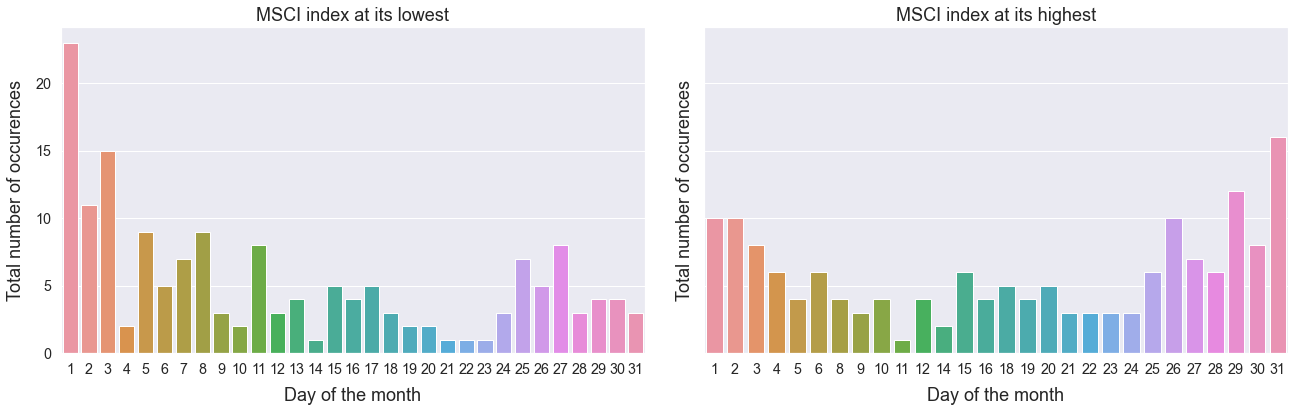

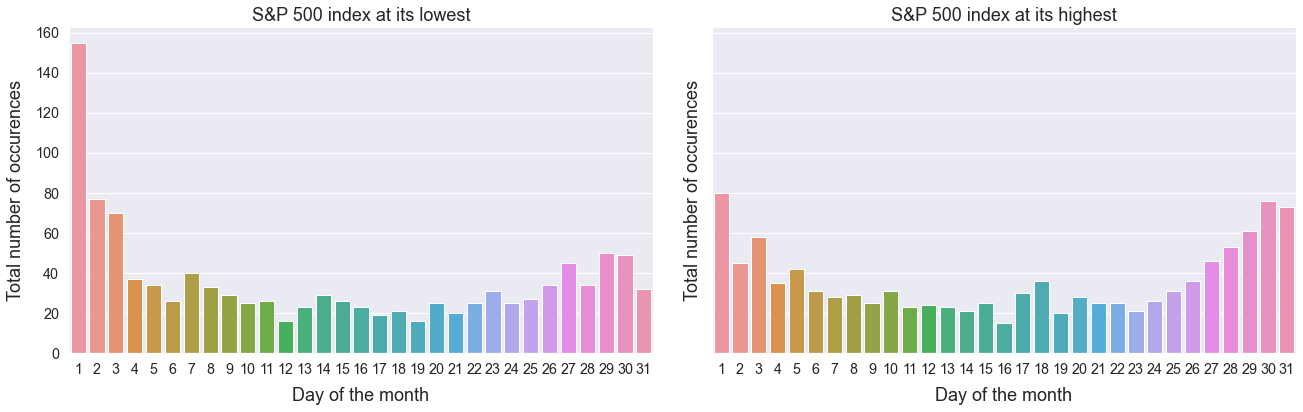

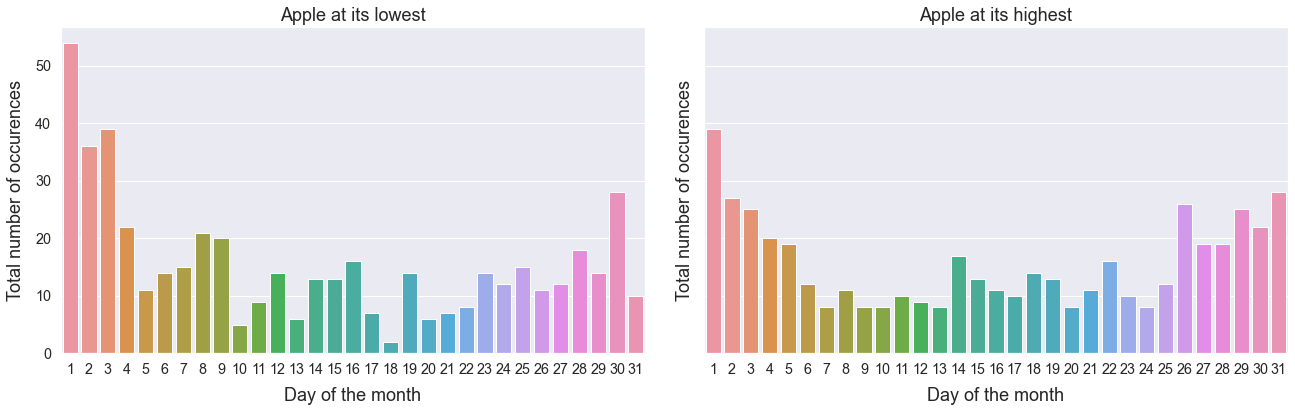

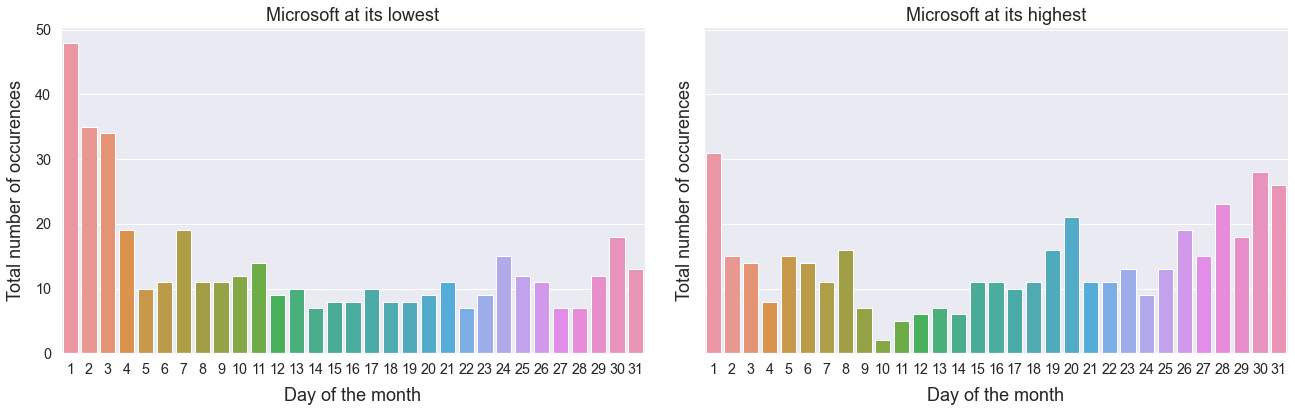

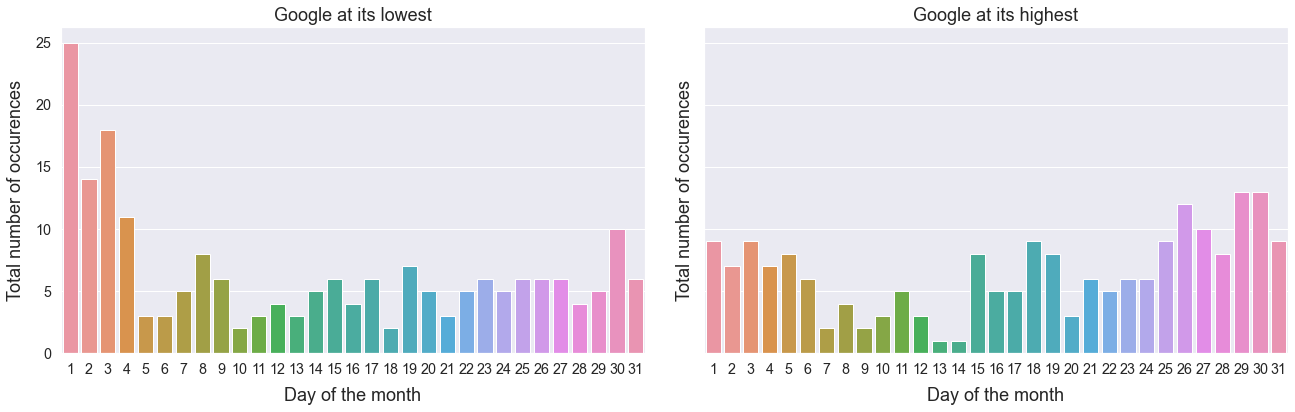

In [493]:
tickers = ['MSCI', '^GSPC', 'AAPL', 'MSFT', 'GOOG'] 
for ticker in tickers:
    subset_min, subset_max = get_subset(ticker)
    subsets = [subset_min, subset_max]
    fig, axs = plt.subplots(1, 2, figsize=(22, 6), sharey=True)
    titles = ['lowest', 'highest']          # to be used as a part of titles
    for i, subset in enumerate(subsets):
        plt.sca(axs[i])
        sns.countplot(x=subset.Day, data=subset)
        axs[i].set_title(f'{subset.Company_name.unique()[0]} at its {titles[i]}', fontsize=18)
        axs[i].set_ylabel('Total number of occurences', labelpad=10, fontsize=18)
        axs[i].set_xlabel('Day of the month', labelpad=10, fontsize=18)
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    plt.show()    

#### Double-checking this by generating 10 random months and plot the monthly closing price data of both MSCI and S&P 500 to observe the trend

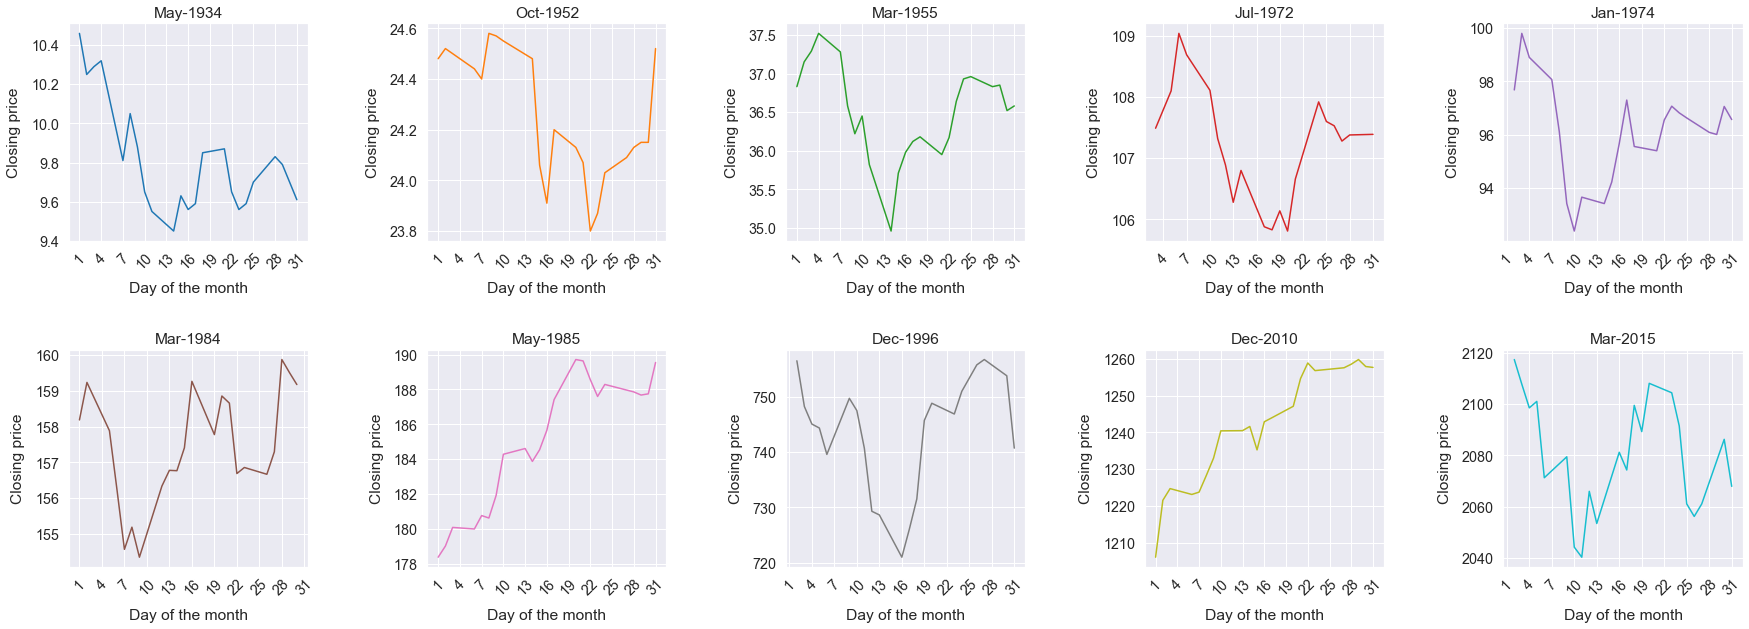

In [862]:
n = 10
half_n = int(n/2)
SP500_subset = data[data.Company=='^GSPC']
date_list = SP500_subset.Date.tolist()
lst = random.sample(date_list, n)
lst.sort()
mon_yr = list(zip(map(get_month, lst), map(get_year, lst)))

fig, axs = plt.subplots(2, half_n, figsize=(30, 10))

zp = zip([0, 1], [mon_yr[:half_n], mon_yr[half_n:]])
colors = list(sns.color_palette("tab10"))

for i, l in zp:
    for j in range(half_n): 
        month, year = l[j]
        mask = (SP500_subset.Month==month) & (SP500_subset.Year==year)
        extract = SP500_subset[mask]
        plt.sca(axs[i, j])
        sns.lineplot(data=extract, x='Day', y='Close', color=colors[i*5+j])
        xticks_loc = list(range(1, 32, 3))
        axs[i, j].xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
        axs[i, j].set_xticklabels(xticks_loc, rotation=45)
        axs[i, j].set_xlabel('Day of the month', labelpad=10)
        axs[i, j].set_ylabel('Closing price', labelpad=10)
        
        axs[i, j].set_title(f'{month[:3]}-{year}')
        
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

#### Did corona crisis affect this trend?

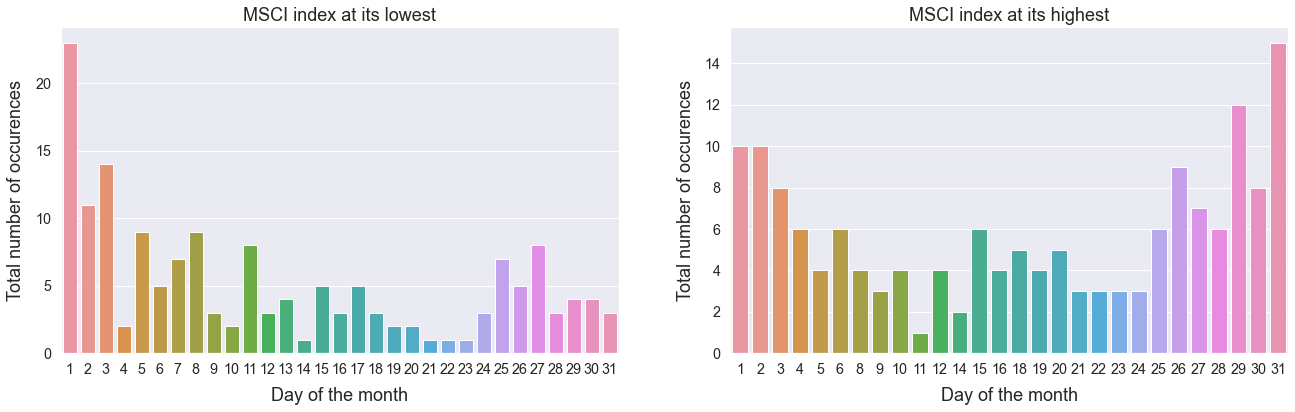

In [494]:
year_mark = 2008
tickers = ['MSCI']#, '^GSPC'] 
for ticker in tickers:
    subset_min, subset_max = get_subset(ticker)
    subsets = [subset_min[subset_min.Year>=year_mark], subset_max[subset_max.Year>=year_mark]]
    fig, axs = plt.subplots(1, 2, figsize=(22, 6))
    titles = ['lowest', 'highest']          # to be used as a part of titles
    for i, subset in enumerate(subsets):
        plt.sca(axs[i])
        sns.countplot(x=subset.Day, data=subset)
        axs[i].set_title(f'{subset.Company_name.unique()[0]} at its {titles[i]}', fontsize=18)
        axs[i].set_ylabel('Total number of occurences', labelpad=10, fontsize=18)
        axs[i].set_xlabel('Day of the month', labelpad=10, fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()  

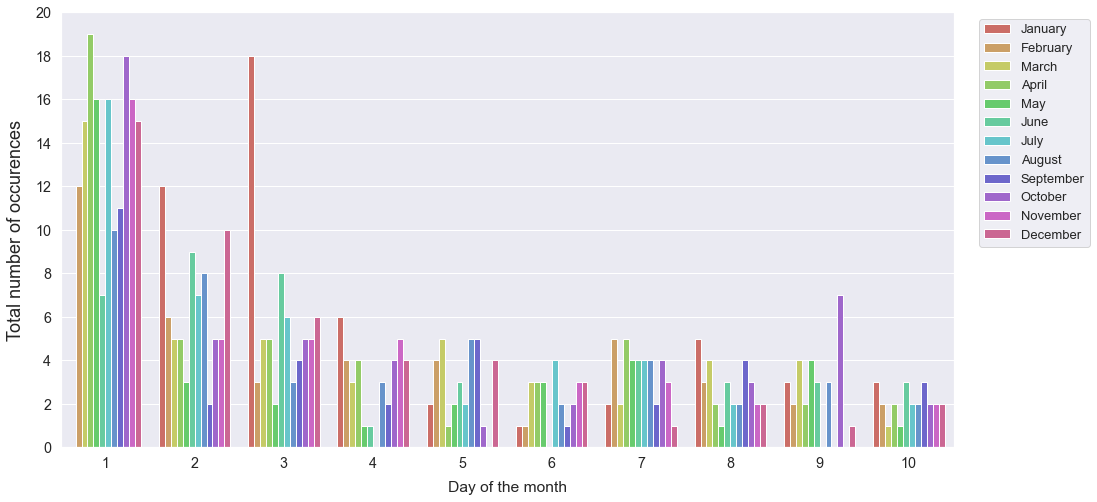

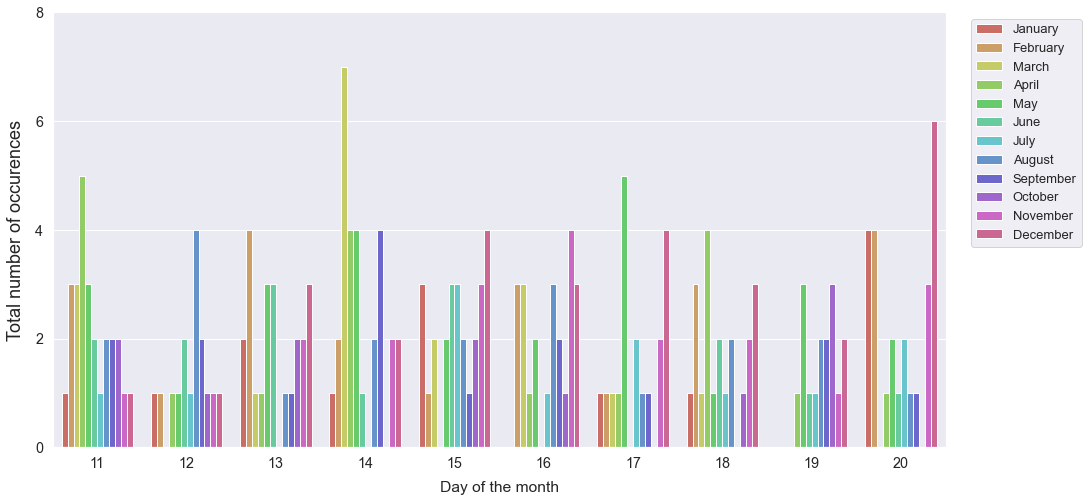

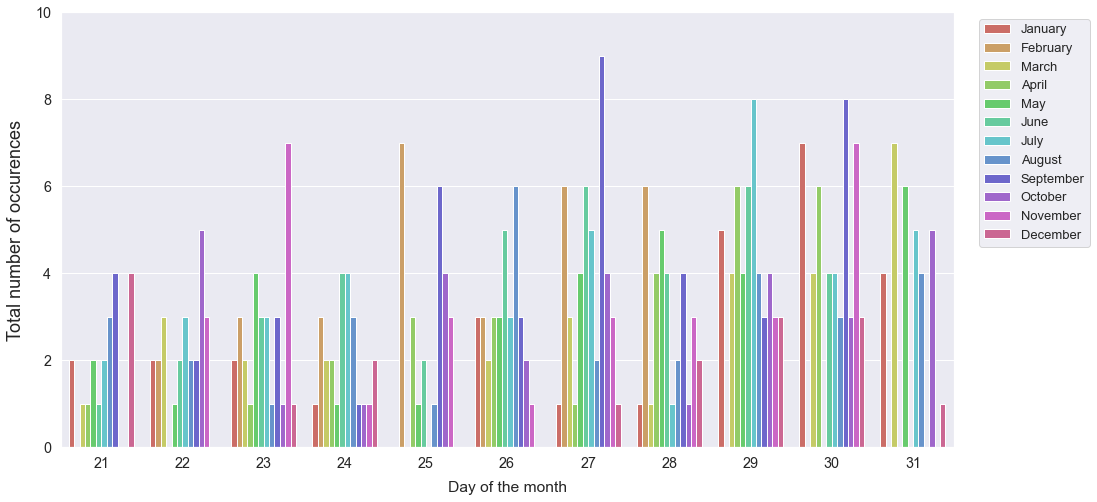

In [769]:
import calendar
month_list = list(calendar.month_name)
month_list.pop(0)
month_list_cut = list(map(lambda x: x[:3], month_list))

ss_min = get_subset('^GSPC')[0]

flter1 = ss_min.Day.isin(list(range(11)))
flter2 = ss_min.Day.isin(list(range(11, 21)))
flter3 = ss_min.Day.isin(list(range(21, 32)))
split_sets = [ss_min[flter1], ss_min[flter2], ss_min[flter3]]
for st in split_sets:
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
    sns.countplot(x='Day', data=st, hue='Month', palette='hls', hue_order=month_list)
    yticks = axs.get_yticks()    # this is a list of y-tick values
    new_yticks = list(range(int(min(yticks)), int(max(yticks))+2, 2))
    axs.set_yticks(new_yticks)
    axs.set_xlabel('Day of the month', labelpad=10)
    axs.set_ylabel('Total number of occurences', labelpad=10, fontsize=18)
    plt.legend(loc='upper right', bbox_to_anchor=[1.16, 1], fontsize=13)

plt.show()

In [566]:
def mean_returns(col):
    lst = col.tolist()
    returns = [j-i for i, j in zip(lst[:-1], lst[1:])]
    mean_returns = np.mean(returns)
    return mean_returns

In [567]:
def volatility(col):
    lst = col.tolist()
    returns = [j-i for i, j in zip(lst[:-1], lst[1:])]
    mean_returns = np.mean(returns)
    volatility = np.std(returns)
    return volatility

In [568]:
def rel_volatility(col):
    lst = col.tolist()
    returns = [j-i for i, j in zip(lst[:-1], lst[1:])]
    mean_returns = np.mean(returns)
    volatility = np.std(returns)
    rel_volatility = volatility/mean_returns*100
    return rel_volatility

In [741]:
ticker = '^GSPC'
min_year = 2008
max_year = 2012
year_list = list(range(min_year, max_year))

another_subset = data[data['Company']==ticker]
another_subset = another_subset.pivot_table(index=['Year', 'Month', 'Company_name'], values=['Close'],
                                            aggfunc=[mean_returns, volatility, rel_volatility])
another_subset.reset_index(inplace=True)
new_col = ['Year', 'Month', 'Company_name', 'mean_returns', 'volatility', 'rel_volatility']
another_subset.columns = new_col

another_subset['abs_rel_vol'] = np.abs(another_subset['rel_volatility'])

indx_list = list(another_subset[another_subset.mean_returns==0].index)
another_subset.drop(index=indx_list, inplace=True)

sequence = dict(zip(month_list, range(12)))
another_subset['Sequence'] = another_subset['Month'].map(sequence)

df = another_subset.pivot_table(index=['Year', 'Month', 'Sequence'], values=['rel_volatility', 'abs_rel_vol'])
df.sort_values(['Year', 'Sequence'], inplace=True)
df.reset_index(inplace=True)

df_filtered = df[df.Year.isin(year_list)]

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
sns.lineplot(x='Month', y='rel_volatility', hue='Year', style='Year', data=df_filtered, palette='tab10', markers=True, markersize=10)
axs.set_ylabel('Relative Volatility of Monthly Returns (%)', labelpad=13)
axs.set_xlabel(axs.get_xlabel(), labelpad=13)
axs.set_xticklabels(month_list_cut)
plt.legend(loc='upper right', bbox_to_anchor=[1.12, 1], fontsize=15)
plt.show()

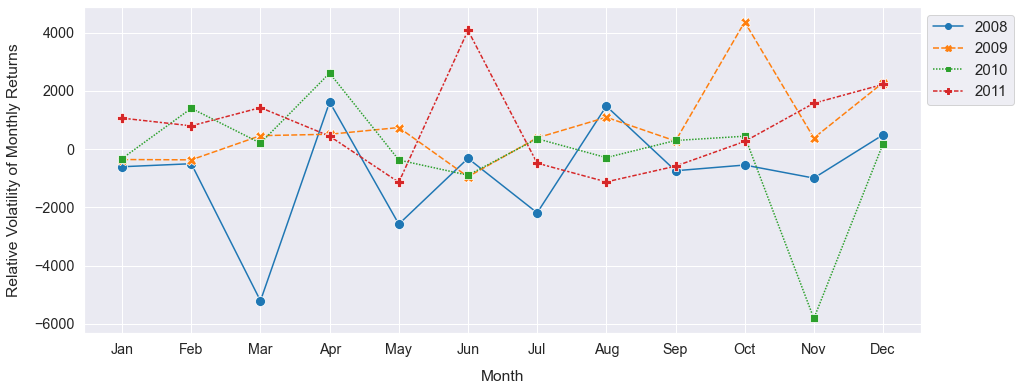

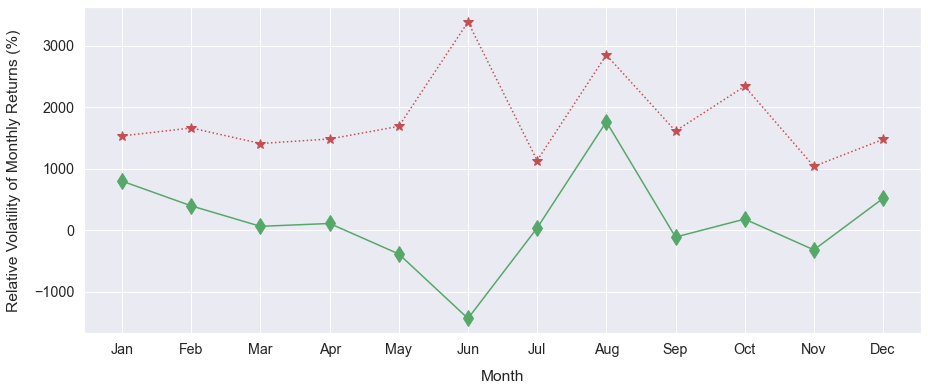

In [808]:
value = ['rel_volatility', 'abs_rel_vol']

df1 = another_subset.pivot_table(index=['Month', 'Sequence'], values=value)
df1.sort_values('Sequence', inplace=True)
df1.reset_index(inplace=True)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
plt.sca(axs)
# sns.lineplot(x='Month', y=value, data=df1, markers=True, markersize=10)
# axs.set_ylabel('Relative Volatility of Monthly Returns', labelpad=13)
# axs.set_xlabel(axs.get_xlabel(), labelpad=13)
# axs.set_xticklabels(month_list_cut)
axs.plot(df1.Month, df1.rel_volatility, 'g-d', df1.Month, df1.abs_rel_vol, 'r:*', markersize=11)
axs.set_xticks(list(range(12)))
axs.set_ylabel('Relative Volatility of Monthly Returns (%)', labelpad=13)
axs.set_xlabel('Month', labelpad=13)
axs.set_xlabel(axs.get_xlabel(), labelpad=13)
axs.set_xticklabels(month_list_cut)
plt.show()

In [809]:
def returns(col):
    lst = col.tolist()
    returns = [j-i for i, j in zip(lst[:-1], lst[1:])]
    return returns

In [810]:
ticker = '^GSPC'
year = 2008

s_set = data[data['Company']==ticker]
s_set = s_set.pivot_table(index=['Year', 'Month', 'Company_name'], values=['Close'], aggfunc=[returns])
s_set.reset_index(inplace=True)
new_col = ['Year', 'Month', 'Company_name', 'Returns']
s_set.columns = new_col

In [821]:
s_set = s_set.explode('Returns')

In [822]:
s_set_filtered = s_set[s_set.Year==year]

In [823]:
s_set_filtered

,Year,Month,Company_name,Returns
961,2008,April,S&P 500 index,-2.65
961,2008,April,S&P 500 index,1.78
961,2008,April,S&P 500 index,1.09
961,2008,April,S&P 500 index,2.14
961,2008,April,S&P 500 index,-7.00
...,...,...,...,...
972,2008,September,S&P 500 index,-2.35
972,2008,September,S&P 500 index,23.31
972,2008,September,S&P 500 index,4.09
972,2008,September,S&P 500 index,-106.85


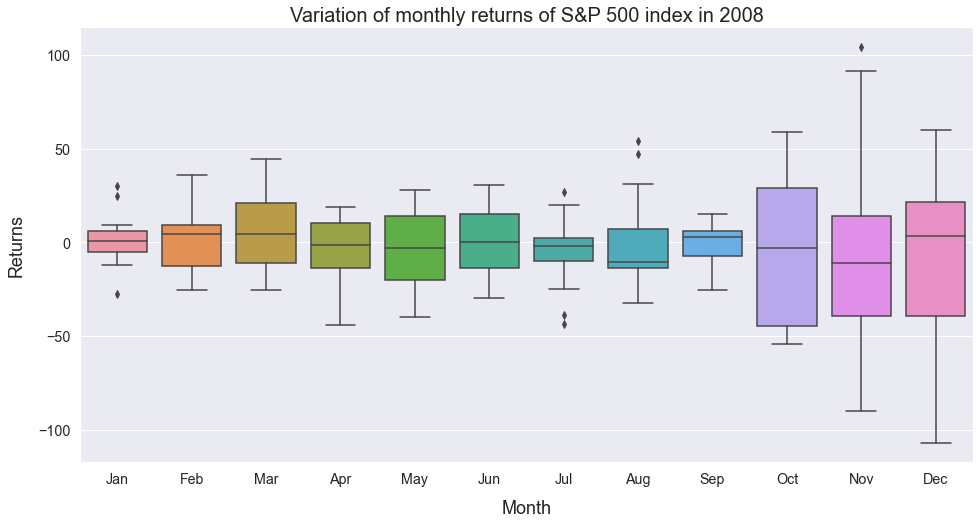

In [839]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(y='Returns', x='Month', data=s_set_filtered)
axs.set_xlabel(axs.get_xlabel(), labelpad=13, fontsize=18)
axs.set_ylabel(axs.get_ylabel(), labelpad=13, fontsize=18)
axs.set_xticklabels(month_list_cut)
plt.title(f'Variation of monthly returns of {s_set_filtered.Company_name.unique()[0]} in {year}', fontsize=20)
plt.show()

In [834]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Holiday,Month,Day,Year,Company_name
0,2007-11-15,23.00,28.45,22.06,26.10,24.15,11770500,MSCI,No,November,15,2007,MSCI index
1,2007-11-16,25.98,25.98,23.60,24.96,23.09,1242900,MSCI,No,November,16,2007,MSCI index
2,2007-11-19,24.71,25.75,24.53,25.75,23.82,469500,MSCI,No,November,19,2007,MSCI index
3,2007-11-20,25.42,29.21,25.26,27.32,25.27,522200,MSCI,No,November,20,2007,MSCI index
4,2007-11-21,27.00,27.13,25.94,26.65,24.65,167500,MSCI,No,November,21,2007,MSCI index


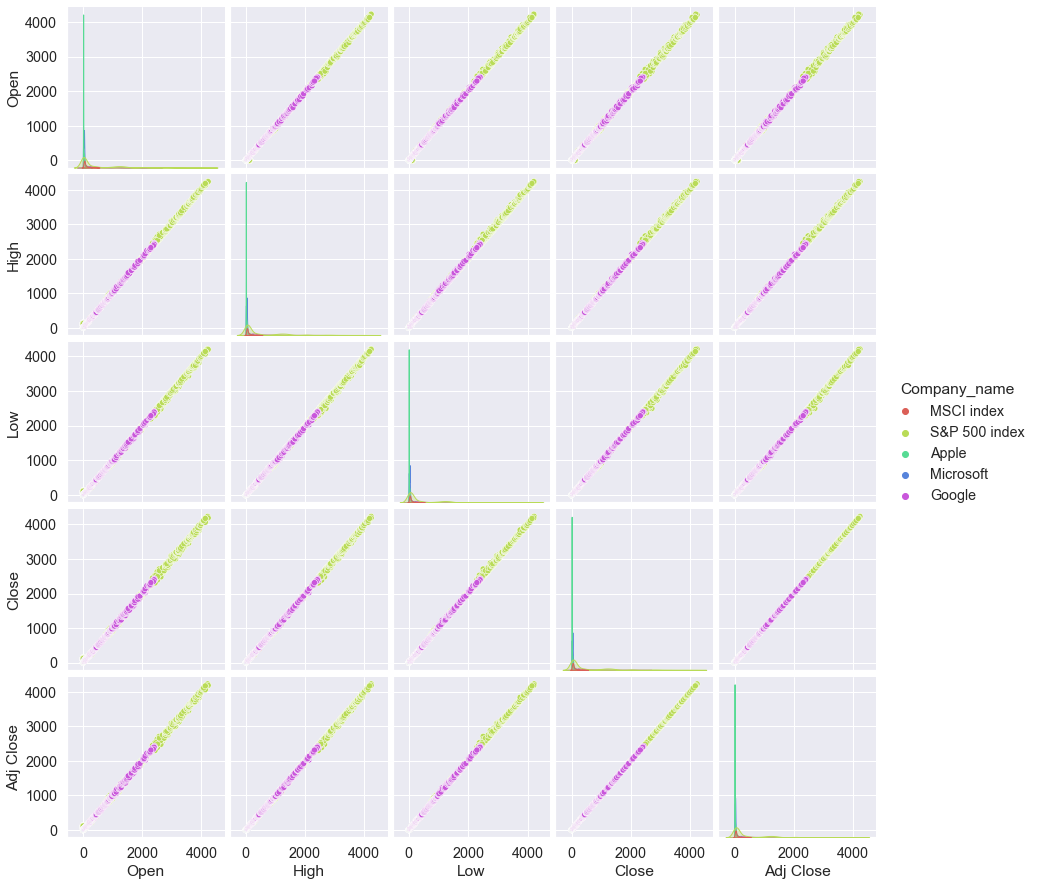

In [852]:
# ticker = '^GSPC'
# s_set1 = data[data.Company==ticker]
s_set1 = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Company_name']]
# fig, axs = plt.subplots(1, 1, figsize=(13, 13))
sns.pairplot(data=s_set1, hue='Company_name', palette='hls')

plt.show()

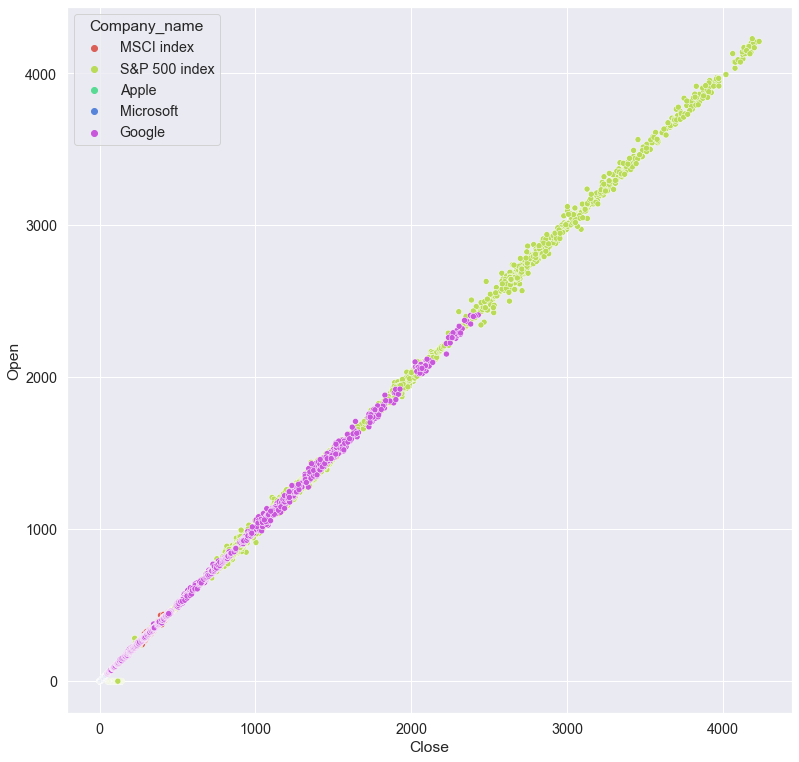

In [857]:
fig, axs = plt.subplots(1, 1, figsize=(13, 13))
sns.scatterplot(x='Close', y='Open', data=s_set1, hue='Company_name', palette='hls')
plt.show()

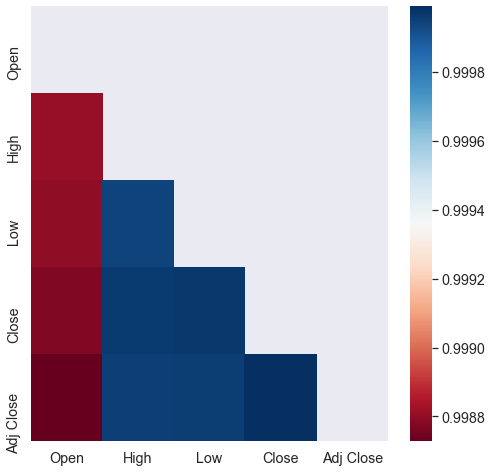

In [860]:
corr = s_set1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(data=corr, cmap="RdBu", mask=mask)
plt.show()